# Clustering Vias Demo

### Usage

#### Important global variables
- `chip_data` contains the complete data from the chip organised into tiles.
- `sorted_cells` contains all cell instances sorted by cell type.

#### Important functions

- `get_aligned_vias(cell_type: str, num_cells : int = 100)` will return a list of all the vias of 100 cells of the given type and the calculated via count. Aligning the cells is very slow so for now I recommend only using up to a few thousand cells.
- `def show_all_cell_types() -> None` will print a list of all the avialable cells in on the chip and how many instances there are.

### What I am trying to achieve:

Find a clustering algorithm that will return repersentative positions for each of the vias. Provided data is the number of vias per cell and the via positions.
Is is important to note that all the points that are acually vias are always grouped together very tightly and each group contains a smilar number of points. All false via detections are eather scattered (more or less randomly) or are part of groups containing far fewer points than the groups containing the actual vias. 


## Imports

In [1]:
import pickle
from collections import Counter
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy
from typing import Any

## Load Data

In [2]:
chip_data_file = "./Data/Vias/Chip_Data_28nm.pickle" # Change this

chip_data = None
with open(chip_data_file, "rb") as f:
    chip_data = pickle.load(f)

tile_list = list(chip_data.keys())
all_cells = []
for tile in tile_list:
    all_cells += chip_data[tile]

sorted_cells = {}
for cell in all_cells:
    if cell["data"]["name"] not in sorted_cells.keys():
        sorted_cells[cell["data"]["name"]] = [cell]
    else:
        sorted_cells[cell["data"]["name"]].append(cell)

## Utilities

### Cell Via utilities

In [3]:
def euk_dist_sq(p1 : tuple[int, int], p2 : tuple[int, int]) -> int:
    return pow(p1[0] - p2[0], 2) + pow(p1[1] - p2[1], 2)

def add_pts(p1 : tuple[int, int], p2 : tuple[int, int]) -> int:
    return p1[0] + p2[0], p1[1] + p2[1]

def diff_pts(p1 : tuple[int, int], p2 : tuple[int, int]) -> int:
    return p1[0] - p2[0], p1[1] - p2[1]

def rotate_cell_180(cell : dict[str, Any]) -> dict[str, Any]:
    cell = deepcopy(cell)
    box = cell["box"]
    box_width = box[1][0] - box[0][0]
    box_height = box[1][1] - box[0][1]
    # reflect y and reflect x == rotate 180
    cell["vias"] = [(v[0], box_height - v[1]) for v in cell["vias"]]
    cell["vias"] = [(box_width - v[0], v[1]) for v in cell["vias"]]
    return cell

def reflect_cell(cell : dict[str, Any], axis : str) -> dict[str, Any]:
    assert axis in ["Y", "X", "y", "x"], "Invalid axis given."
    cell = deepcopy(cell)
    box = cell["box"]
    box_width = box[1][0] - box[0][0]
    box_height = box[1][1] - box[0][1]
    if axis.lower() == "y":
        cell["vias"] = [(v[0], box_height - v[1]) for v in cell["vias"]] # powerline direction Y
    else:
        cell["vias"] = [(box_width - v[0], v[1]) for v in cell["vias"]] # powerline direction X_filtered
    return cell

def reset_transform(cell : dict[str, Any], powerline_direction : str) -> dict[str, Any]:
    """Transform the cell back to rotation = 0 and no reflection."""

    if cell["data"]["rotation"] == 180 and cell["data"]["reflection"]:
        return reflect_cell(cell, "x" if powerline_direction == "y" else "y")
    if cell["data"]["rotation"] == 180:
        return rotate_cell_180(cell)
    if cell["data"]["reflection"]:
        return reflect_cell(cell, powerline_direction)
    return cell

# try to match pts1 to pts2
def score_matching(pts1 : list[tuple[int, int]], pts2 : list[tuple[int, int]]) -> int:
    """Try to match the set of points 1 to points 2. The points of set 1 are matched to the closest
    point in set 2. The resulting score is the sum of the distances"""

    min_dists = []
    for p1 in pts1:
        dists = [euk_dist_sq(p1, p2) for p2 in pts2]
        min_dists.append(min(dists))
    return sum(min_dists)

def align_to_point(vias : list[tuple[int, int]], point : tuple[int, int]):
    return [diff_pts(point, v) for v in vias]

def align_cells(cell1_vias : list[tuple[int, int]], cell2_vias : list[tuple[int, int]], itr_count: int = 5):
    """ Given to sets of vias (points) try to align them as well as possible. For the optimal results all points
    would have to be tested but in all cases 5 works well enough. To use all points set itr_count to -1."""

    cell1, cell2 = deepcopy(cell1_vias), deepcopy(cell2_vias)
    min_scores = []

    for p1 in cell1[:itr_count]:
        # Set the chosen via in cell1 to (0, 0).
        p1_aligned_cell1 = align_to_point(cell1, p1)

        # Make a list where every point in cell2 is aligned to (0, 0) once.
        alignments_p2 = [(p2, align_to_point(cell2, p2)) for p2 in cell2]

        # Score all the alignments bettween cell1 and cell2
        fitting_scores = [(p1, p2, score_matching(c2, p1_aligned_cell1)) for p2, c2 in alignments_p2]

        min_scores.append(min(fitting_scores, key = lambda x : x[2]))
    p1_alignment, p2_alignment, score = min(min_scores, key = lambda x : x[2])
    aligned_cell1, aligned_cell2 = [diff_pts(p1, p1_alignment) for p1 in cell1], [diff_pts(p2, p2_alignment) for p2 in cell2]
    aligned_cell1, aligned_cell2 = [add_pts(p1, p1_alignment) for p1 in aligned_cell1], [add_pts(p2, p1_alignment) for p2 in aligned_cell2]
    return aligned_cell1, aligned_cell2

def get_aligned_vias(cell_type: str, num_cells : int = 100, alignment_itr : int = 7) -> tuple[int, np.array]:
    """Choose a cell type and get a list of all the aligned vias from a chosen number of instances."""
    # Transform all the cells to the same orientation
    cells = [reset_transform(c, "y") for c in sorted_cells[cell_type]]

    # Majority vote on the number of vias in the cell
    via_counter = Counter([len(cell["vias"]) for cell in cells])
    via_count = via_counter.most_common(1)[0][0]

    # Choose a good starting cell
    start_cell = None
    for i, cell in enumerate(cells):
        if len(cell["vias"]) == via_count:
            start_cell = cells.pop(i)
            break
    assert start_cell is not None, "Something went wrong. Start cell should not be None."

    # Extract all aligned vias from the cells
    all_vias = deepcopy(start_cell["vias"])
    for cell in cells[:num_cells]:
        _, vias_p2  = align_cells(start_cell["vias"], cell["vias"], itr_count=alignment_itr)
        all_vias += vias_p2
    return via_count, np.array(all_vias)

### Visualisation

In [4]:
def display_points(pts : np.array, ) -> None:
    plt.scatter(pts[:, 0], pts[:, 1], zorder=0)

def show_all_cell_types() -> None:
    for cell_type in sorted_cells.keys():
        print(f"{cell_type : <20}{len(sorted_cells[cell_type])}")

## Example of goal :

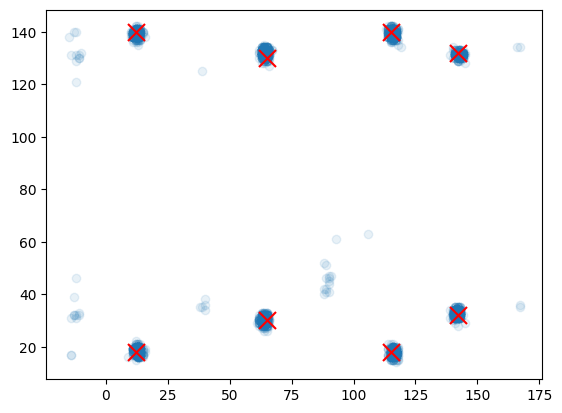

In [5]:
cell_type = "ANQ"
via_count, cell_vias = get_aligned_vias(cell_type, num_cells=1000)
plt.scatter(cell_vias[:, 0], cell_vias[:, 1], zorder=0, alpha=0.1)

# This is what I am trying to compute!
cluster_centers = np.array([[12, 18], [12, 140], [65, 30], [65, 130], [115, 18], [115, 140], [142, 32], [142, 132]])

plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], color="r", marker="x", s=150, zorder=1)
plt.show()

## Clustering Vias

In [6]:
print([(name, len(liste)) for name, liste in sorted_cells.items()])

[('FILL_BLO', 125720), ('FILL_BLQ', 92534), ('BLS', 32412), ('FILL_BLU', 191325), ('BLE', 41860), ('FILL_BLC', 141125), ('BLG', 51471), ('FILL_BLI', 56538), ('FILL_BLK', 75684), ('FILL_BKY', 70645), ('BLA', 12230), ('FILL_BKW', 54551), ('FILL_BLM', 114688), ('BKQ', 22353), ('BKO', 1398), ('BKM', 11772), ('BKU', 29186), ('FILL_C', 36209), ('BJS', 1594), ('BKS', 27812), ('BKE', 4224), ('BJO', 14322), ('BJQ', 10002), ('BKK', 19044), ('BKI', 8787), ('BGE', 6734), ('BIQ', 35654), ('BCY', 348), ('BEC', 4529), ('BDM', 9773), ('BES', 7396), ('BBK', 5768), ('BCG', 3200), ('BIA', 6866), ('BGC', 2621), ('BFS', 341), ('FILL_BKC', 14323), ('BGW', 375), ('BKG', 287), ('FILL_BII', 1734), ('FILL_BGS', 1183), ('FILL_BIK', 1268), ('FILL_BGU', 514), ('AXG', 33), ('FILL_BGQ', 914), ('AXM', 34), ('AZY', 135), ('AWS', 54), ('AYC', 34), ('FILL_A', 17227), ('BBW', 1837), ('BDA', 274), ('BIU', 21927), ('BEK', 166), ('BJM', 1576), ('BHK', 1052), ('BJK', 2047), ('BJU', 242), ('BHQ', 682), ('BHC', 581), ('BHA', 1

In [7]:
cell_type = "ANQ"
via_count, cell_vias = get_aligned_vias(cell_type, num_cells=1000)

X = cell_vias

print(via_count)


8


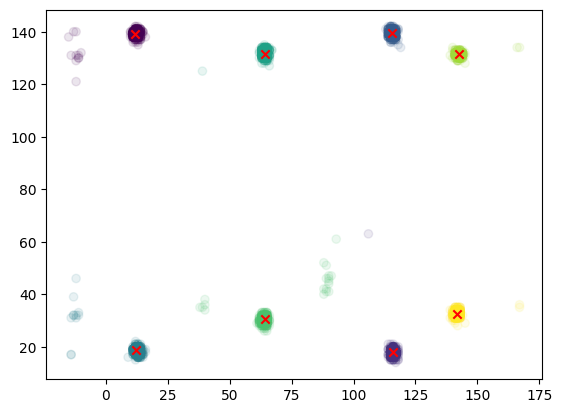

In [8]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=via_count)
kmeans.fit(X)


Y_ = kmeans.predict(X)


plt.scatter(X[:, 0], X[:, 1], c=Y_, alpha=0.1)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', c='r')
plt.show()


0.20060107615844663 3.311273717703118


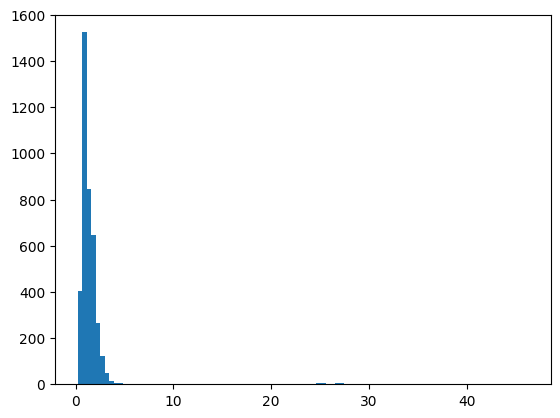

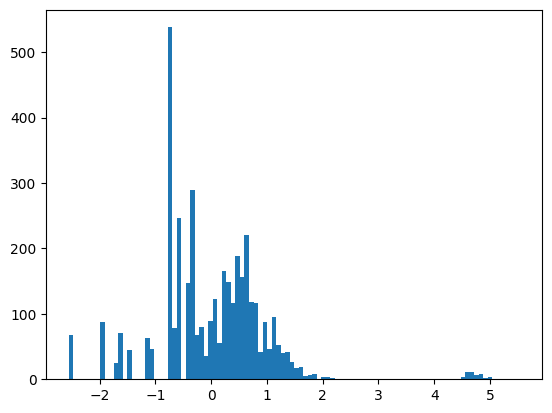

0


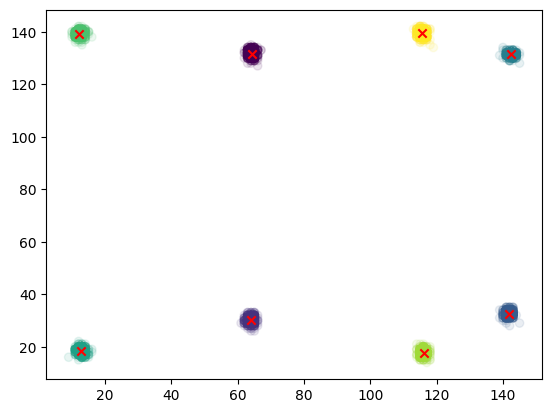

0.15219926102581688 1.2484042666318513


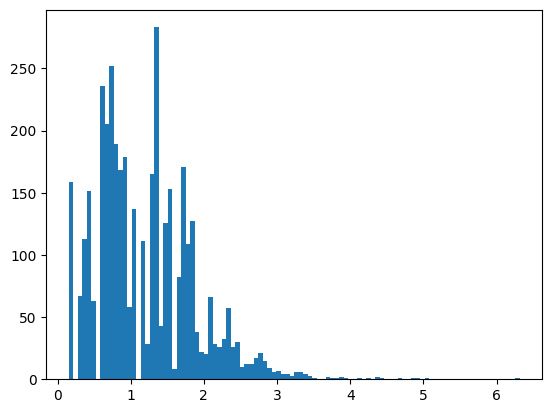

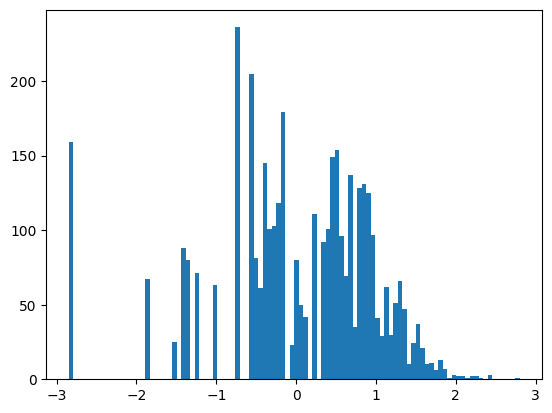

11


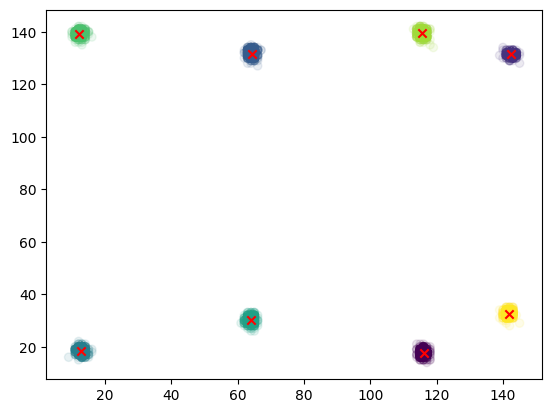

0.15219926102581688 1.2484042666318513


In [9]:
import numpy as np
from scipy import stats

X_filtered = X

kmeans_filtered = kmeans

sigma_old = 100
sigma = 0

while sigma != sigma_old:
    labels = kmeans_filtered.labels_

    distances = np.zeros(len(X_filtered))
    for i in range(len(X_filtered)):
        cluster_center = kmeans_filtered.cluster_centers_[labels[i]]
        distances[i] = np.linalg.norm(X_filtered[i] - cluster_center)

    sigma_old = sigma
    mu, sigma, *rest = stats.halfnorm.fit(distances) # If the distances are normal distributed then the absolute vales are halfnormal distributed
    print(mu, sigma, *rest)
    # mu, sigma, *rest = stats.norm.fit(distances)
    # print(mu, sigma, *rest)
    # mu, sigma, *rest = stats.chi.fit(distances)
    # print(mu, sigma, *rest)
    # mu, sigma, *rest = stats.alpha.fit(distances)
    # print(mu, sigma, *rest)
    if sigma == sigma_old:
        break

    normal_distributed = stats.gzscore(distances, nan_policy='omit')


    plt.hist(distances, bins=100)
    plt.show()
    plt.hist(normal_distributed, bins=100)
    plt.show()

    # Find points within threshold
    is_inlier = distances <= mu + 3 * sigma
    is_inlier_n = normal_distributed <= 3
    print(sum(is_inlier ^ is_inlier_n))
    X_filtered = X_filtered[is_inlier_n]  # Hier aussuchen, wie man filtern möchte.


    kmeans_filtered = KMeans(n_clusters=via_count)
    kmeans_filtered.fit(X_filtered)


    Y_ = kmeans_filtered.predict(X_filtered)

    plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=Y_, alpha=0.1)
    plt.scatter(kmeans_filtered.cluster_centers_[:, 0], kmeans_filtered.cluster_centers_[:, 1], marker='x', c='r')
    plt.show()

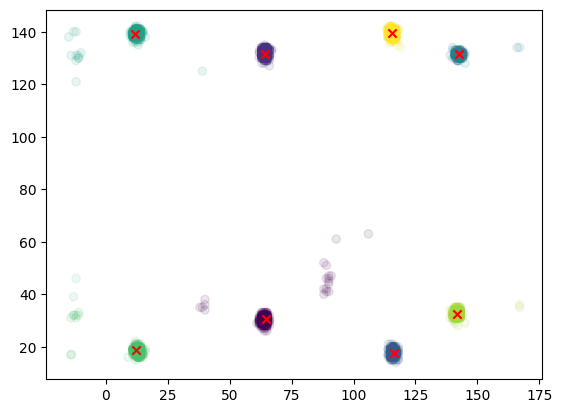

In [10]:
from sklearn.mixture import  GaussianMixture

gmm = GaussianMixture(
    n_components=via_count,
    covariance_type='spherical',
)
gmm.fit(X)

Y_ = gmm.predict(X)


plt.scatter(X[:, 0], X[:, 1], c=Y_, alpha=0.1)
plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], marker='x', c='r')
plt.show()

0.23931714880199914 3.3289550871309315


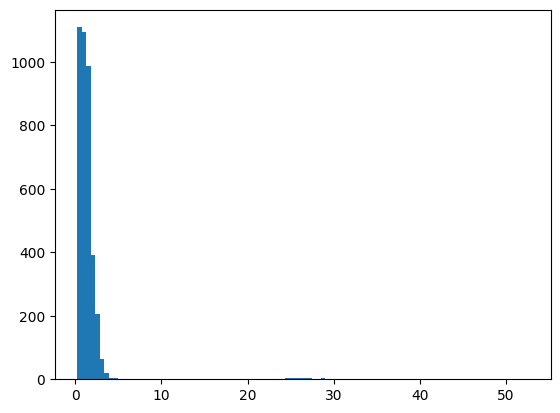

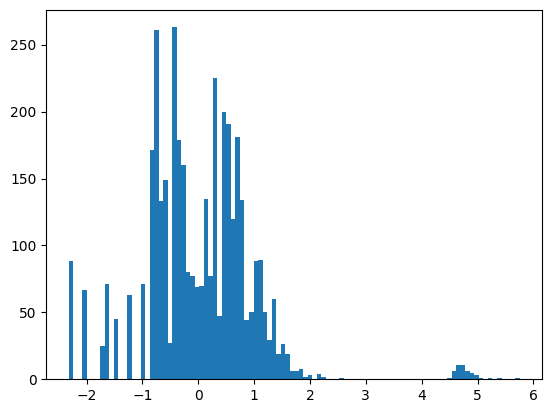

0


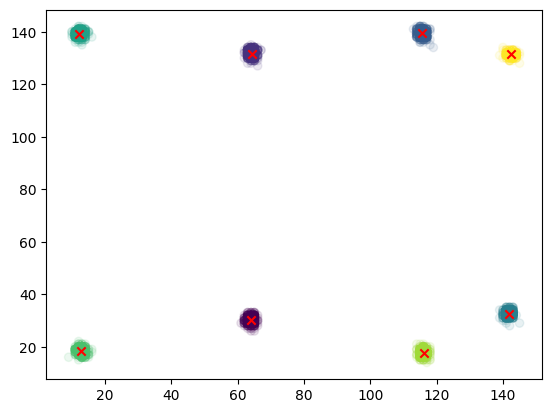

0.15219926102578424 1.2484042666318789


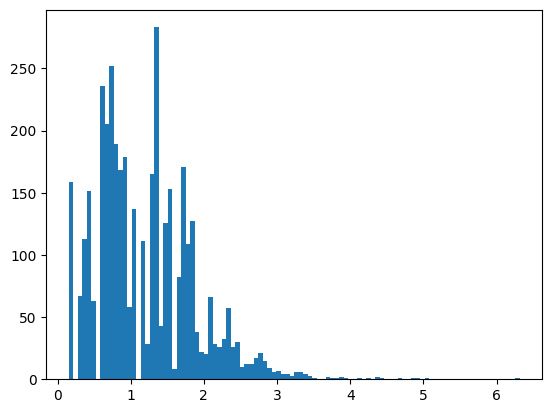

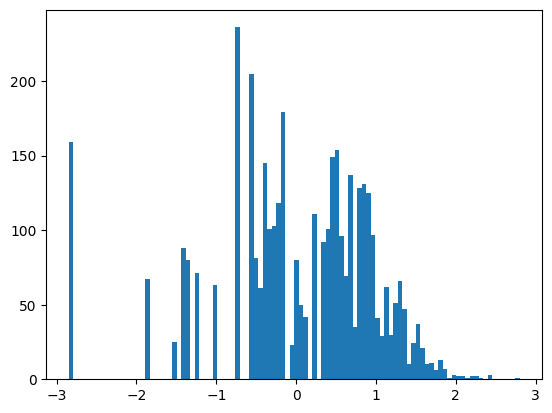

11


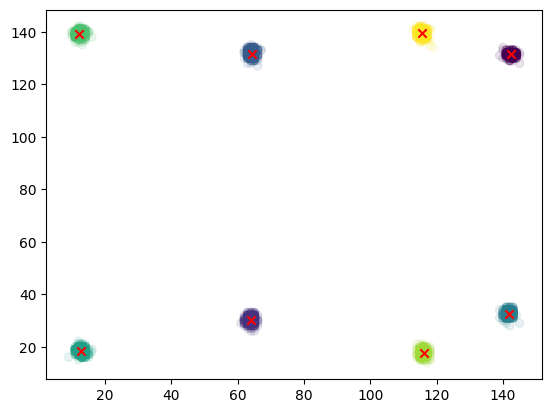

0.15219926102578424 1.2484042666318789


In [11]:
import numpy as np
from scipy import stats

X_filtered = X

gmm_filtered = gmm

sigma_old = 100
sigma = 0

while sigma != sigma_old:
    labels = gmm_filtered.predict(X_filtered)

    distances = np.zeros(len(X_filtered))
    for i in range(len(X_filtered)):
        cluster_center = gmm_filtered.means_[labels[i]]
        distances[i] = np.linalg.norm(X_filtered[i] - cluster_center)

    sigma_old = sigma
    mu, sigma, *rest = stats.halfnorm.fit(distances) # If the distances are normal distributed then the absolute vales are halfnormal distributed
    print(mu, sigma, *rest)
    # mu, sigma, *rest = stats.norm.fit(distances)
    # print(mu, sigma, *rest)
    # mu, sigma, *rest = stats.chi.fit(distances)
    # print(mu, sigma, *rest)
    # mu, sigma, *rest = stats.alpha.fit(distances)
    # print(mu, sigma, *rest)
    if sigma == sigma_old:
        break

    normal_distributed = stats.gzscore(distances)


    plt.hist(distances, bins=100)
    plt.show()
    plt.hist(normal_distributed, bins=100)
    plt.show()

    # Find points within threshold
    is_inlier = distances <= mu + 3 * sigma
    is_inlier_n = normal_distributed <= 3
    print(sum(is_inlier ^ is_inlier_n))
    X_filtered = X_filtered[is_inlier_n]  # Hier aussuchen, wie man filtern möchte.

    gmm_filtered = GaussianMixture(n_components=via_count)
    gmm_filtered.fit(X_filtered)


    Y_ = gmm_filtered.predict(X_filtered)

    plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=Y_, alpha=0.1)
    plt.scatter(gmm_filtered.means_[:, 0], gmm_filtered.means_[:, 1], marker='x', c='r')
    plt.show()

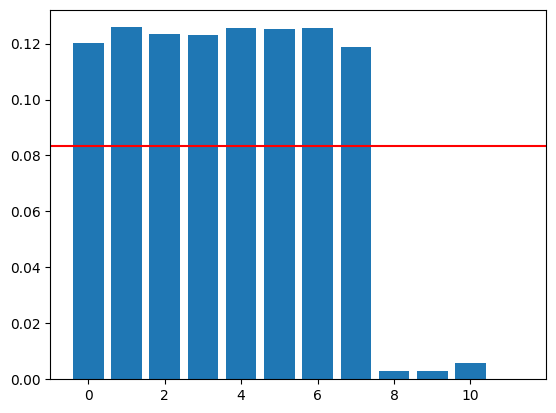

8


In [12]:
from sklearn.mixture import  BayesianGaussianMixture

lose_upper_bound = int(via_count*(1.5))

bgmm = BayesianGaussianMixture(
    n_components=lose_upper_bound,
    covariance_type='spherical',
    mean_precision_prior=.001,
)
bgmm.fit(X)

plt.bar(range(lose_upper_bound), bgmm.weights_)
plt.axhline((1)/lose_upper_bound, c='r')
plt.show()

lose_lower_bound_weights = (1)/lose_upper_bound

num = sum([1 for weight in bgmm.weights_ if weight > lose_lower_bound_weights])
print(num)

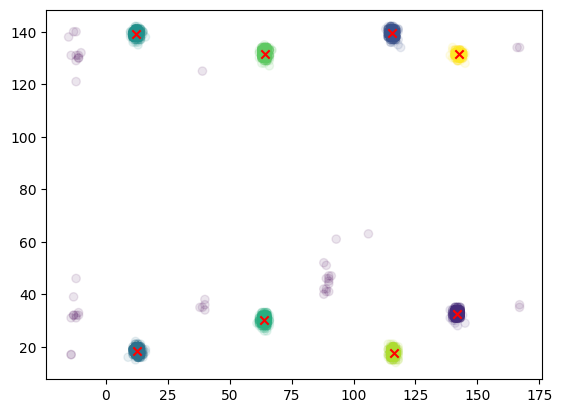

In [13]:
import numpy as np

Y_ = bgmm.predict(X)


means = bgmm.means_[bgmm.weights_ > lose_lower_bound_weights]
Y_[bgmm.weights_[Y_] < lose_lower_bound_weights] = -1


plt.scatter(X[:, 0], X[:, 1], c=Y_, alpha=0.1)
plt.scatter(means[:, 0], means[:, 1], marker='x', c='r')
plt.show()